In [1]:
# Import Econ-ARK styling and display header
from style import (
    HEADER_HTML_NOTEBOOK,
    apply_ark_style,
    apply_notebook_css,
)

# Apply Econ-ARK branding and styling
apply_ark_style()
apply_notebook_css()

# Official ECON-ARK Brand Colors Available (ONLY APPROVED):
# ARK_BLUE (#1f476b) - Primary brand blue
# ARK_LIGHTBLUE (#00aeef) - Accent light blue
# ARK_PINK (#ed217c) - Brand pink
# ARK_GREEN (#39b54a) - Brand green
# ARK_YELLOW (#fcb040) - Brand yellow
# ARK_GREY (#676470) - Brand grey

# Display Econ-ARK header (for Jupyter notebooks)
from IPython.display import HTML, display

display(HTML(HEADER_HTML_NOTEBOOK))

(notebook:illustrative)=
# The Method of Moderation: Illustrative Notebook

**Author:** <span style="color: var(--ark-lightblue); font-weight: bold;">Alan Lujan</span>, <span style="color: var(--ark-blue); font-weight: bold;">Johns Hopkins University</span>

The Method of Moderation (MoM) solves the **extrapolation problem** that affects sparse grid implementations of the Endogenous Grid Method (EGM). When EGM extrapolates beyond its computed grid, it can predict negative precautionary saving, violating economic theory. MoM prevents this by using theoretically-grounded bounds and asymptotically linear transformations.

**Key insight**: Optimal consumption is always bounded between analytical "optimist" and "pessimist" solutions. MoM interpolates a transformed ratio that respects these bounds, ensuring economically sensible extrapolation.

In [2]:
from __future__ import annotations

import numpy as np
from moderation import (
    IndShockEGMConsumerType,
    IndShockMoMConsumerType,
)
from plotting import (
    plot_chi_function,
    plot_consumption_bounds,
    plot_moderation_ratio,
    plot_mom_mpc,
    plot_precautionary_gaps,
    plot_value_functions,
)

# Model setup: Consumer with income uncertainty
params = {
    "CRRA": 2.0,
    "DiscFac": 0.96,
    "Rfree": [1.02],
    "TranShkStd": [1.0],
    "cycles": 1,
    "LivPrb": [1.0],
    "vFuncBool": True,
    "CubicBool": True,
    "PermGroFac": [1.0],
    "PermShkStd": [0.0],
    "TranShkCount": 7,
    "UnempPrb": 0.0,
    "BoroCnstArt": None,
}

# Dense grid for "truth" solution (high precision)
dense_grid = {"aXtraMin": 0.001, "aXtraMax": 40, "aXtraCount": 500, "aXtraNestFac": 3}

# Sparse grid for practical comparison (5 points only)
sparse_grid = {"aXtraMin": 0.001, "aXtraMax": 4, "aXtraCount": 5, "aXtraNestFac": -1}

# Solve three versions: Truth (dense EGM), Sparse EGM, Sparse MoM
IndShockTruth = IndShockEGMConsumerType(**(params | dense_grid))
IndShockTruth.solve()
IndShockTruthSol = IndShockTruth.solution[0]

# Unpack theoretical bounds (same for all methods)
TruthOpt = IndShockTruthSol.Optimist
TruthPes = IndShockTruthSol.Pessimist
TruthTight = IndShockTruthSol.TighterUpperBound

# Sparse EGM solution (standard approach)
IndShockEGMApprox = IndShockEGMConsumerType(**(params | sparse_grid))
IndShockEGMApprox.solve()
IndShockEGMApproxSol = IndShockEGMApprox.solution[0]

# Sparse MoM solution (same grid, different method)
IndShockMoMApprox = IndShockMoMConsumerType(**(params | sparse_grid))
IndShockMoMApprox.solve()
IndShockMoMApproxSol = IndShockMoMApprox.solution[0]

# Grid parameters for plotting
mNrmMax = IndShockMoMApproxSol.mNrmMin + IndShockMoMApprox.aXtraGrid.max()

**Setup**: Three solutions using identical economic parameters. The "truth" uses a dense 500-point grid, while EGM and MoM use a realistic 5-point sparse grid. The test: which method extrapolates better beyond the computed grid?

(notebook:figure1)=
## Consumption Function Analysis

### Figure 1: The EGM Extrapolation Problem

The key test of any solution method is its **extrapolation properties**: how well does it predict behavior outside the computed grid? Economic theory tells us that the gap between optimist and realist consumption (the "precautionary saving gap") should always be positive - consumers should always save more than the optimist due to income uncertainty.

**EGM struggles with this extrapolation challenge, as {ref}`demonstrated in the paper <benchmark-the-method-of-endogenous-gridpoints>`.**

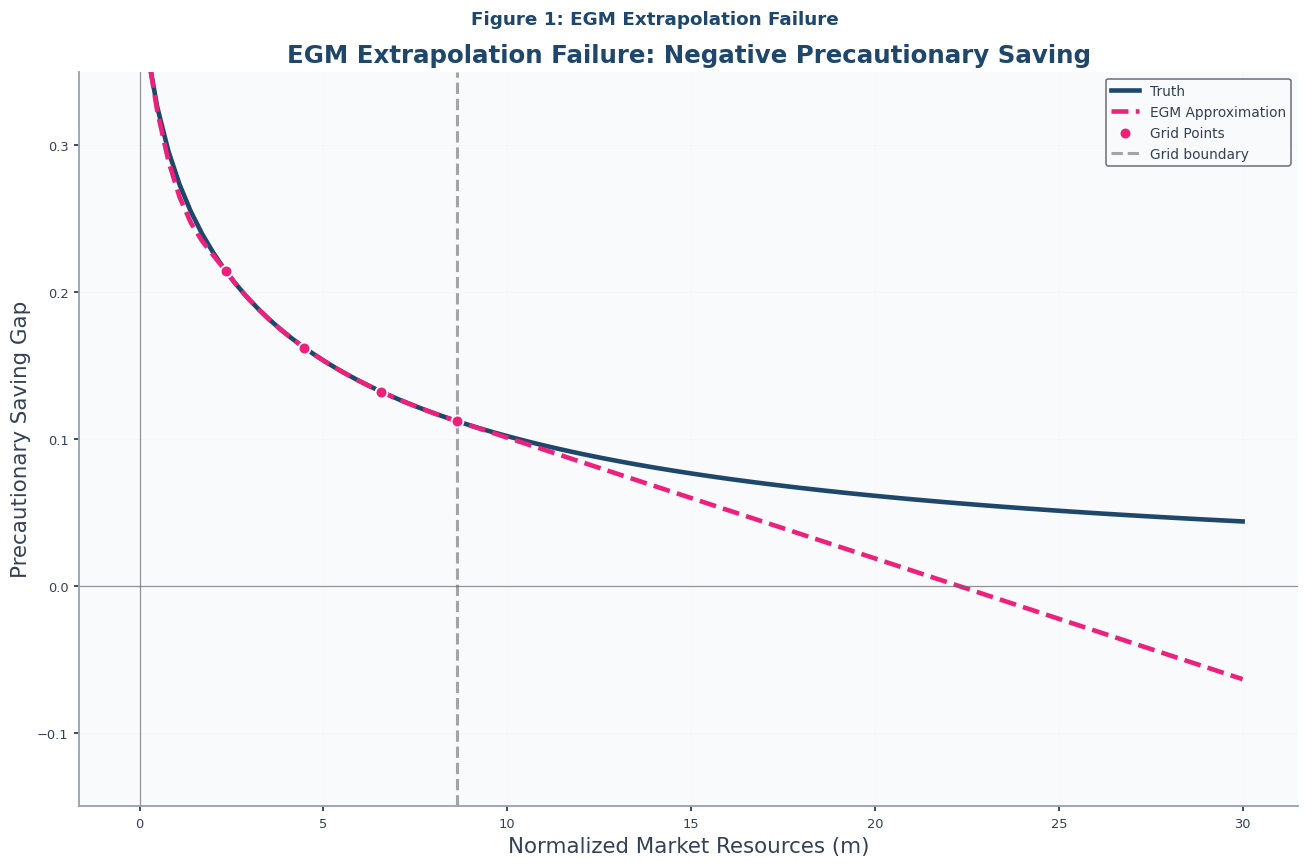

In [3]:
# Define the precautionary saving gap functions
def truth_gap(m):
    """True precautionary saving gap."""
    return TruthOpt.cFunc(m) - IndShockTruthSol.cFunc(m)


def egm_approx_gap(m):
    """EGM approximation gap."""
    return TruthOpt.cFunc(m) - IndShockEGMApproxSol.cFunc(m)


# Test extrapolation over a wide range including high wealth levels
# Extend from near borrowing constraint to high wealth to capture all grid points
m_grid_wide = np.linspace(IndShockEGMApproxSol.mNrmMin + 0.001, 30, 100)

# Figure 1: EGM Extrapolation Failure
# Grid points will be handled internally by plotting functions

plot_precautionary_gaps(
    m_grid=m_grid_wide,
    truth_gap=truth_gap(m_grid_wide),
    approx_gap=egm_approx_gap(m_grid_wide),
    legend="EGM Approximation",
    title="Figure 1: EGM Extrapolation Failure",
    subtitle="EGM Extrapolation Failure: Negative Precautionary Saving",
    solution=IndShockEGMApproxSol,
    grid_points=True,
)

```{note} EGM vs MoM Extrapolation
Figure 1 demonstrates the core difference: **EGM** can predict negative precautionary saving (violating economic theory), while **MoM** maintains positive precautionary saving through asymptotically linear extrapolation.
```

(notebook:figure2)=
### Figure 2: Truth Bounded by Theory

Before showing how MoM solves the problem, let's understand the theoretical foundation. The true optimal consumption function is always bounded between two extreme cases with known analytical solutions.

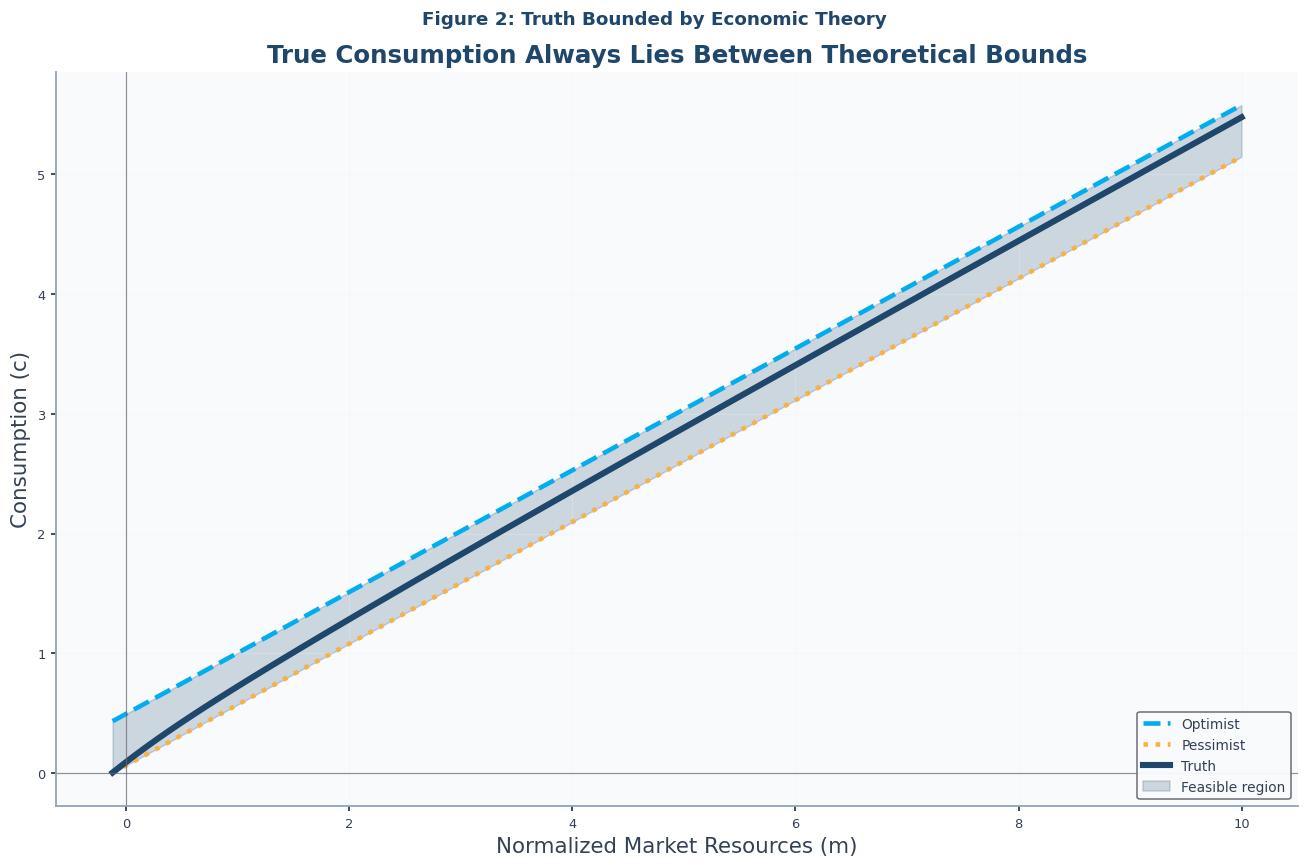

In [4]:
# Create wealth grid for evaluation and plotting (matches paper ranges)
m_grid = np.linspace(IndShockTruthSol.mNrmMin + 0.01, 10, 100)

# Evaluate consumption functions on the grid
c_truth = IndShockTruthSol.cFunc(m_grid)  # True optimal consumption
c_opt = TruthOpt.cFunc(m_grid)  # Optimist consumption
c_pes = TruthPes.cFunc(m_grid)  # Pessimist consumption

# Figure 2: Truth Bounded by Theory
plot_consumption_bounds(
    m_grid=m_grid,
    c_main=c_truth,
    c_opt=c_opt,
    c_pes=c_pes,
    title="Figure 2: Truth Bounded by Economic Theory",
    subtitle="True Consumption Always Lies Between Theoretical Bounds",
    legend="Truth",
    grid_points=False,  # No grid points for theoretical bounds
)

```{tip} Key Theoretical Insight
The realist consumption function $\cFuncReal(\mNrm)$ lies between the optimist $\cFuncOpt(\mNrm)$ and pessimist $\cFuncPes(\mNrm)$ bounds, reflecting precautionary saving motives. This theoretical constraint $\cFuncPes(\mNrm) \leq \cFuncReal(\mNrm) \leq \cFuncOpt(\mNrm)$ is the foundation for the Method of Moderation.
```

(notebook:figure3)=
### Figure 3: Method of Moderation Solution

The Method of Moderation leverages the theoretical bounds to achieve superior extrapolation. Instead of extrapolating consumption directly, `MoM` interpolates a transformed ratio that respects the bounds.

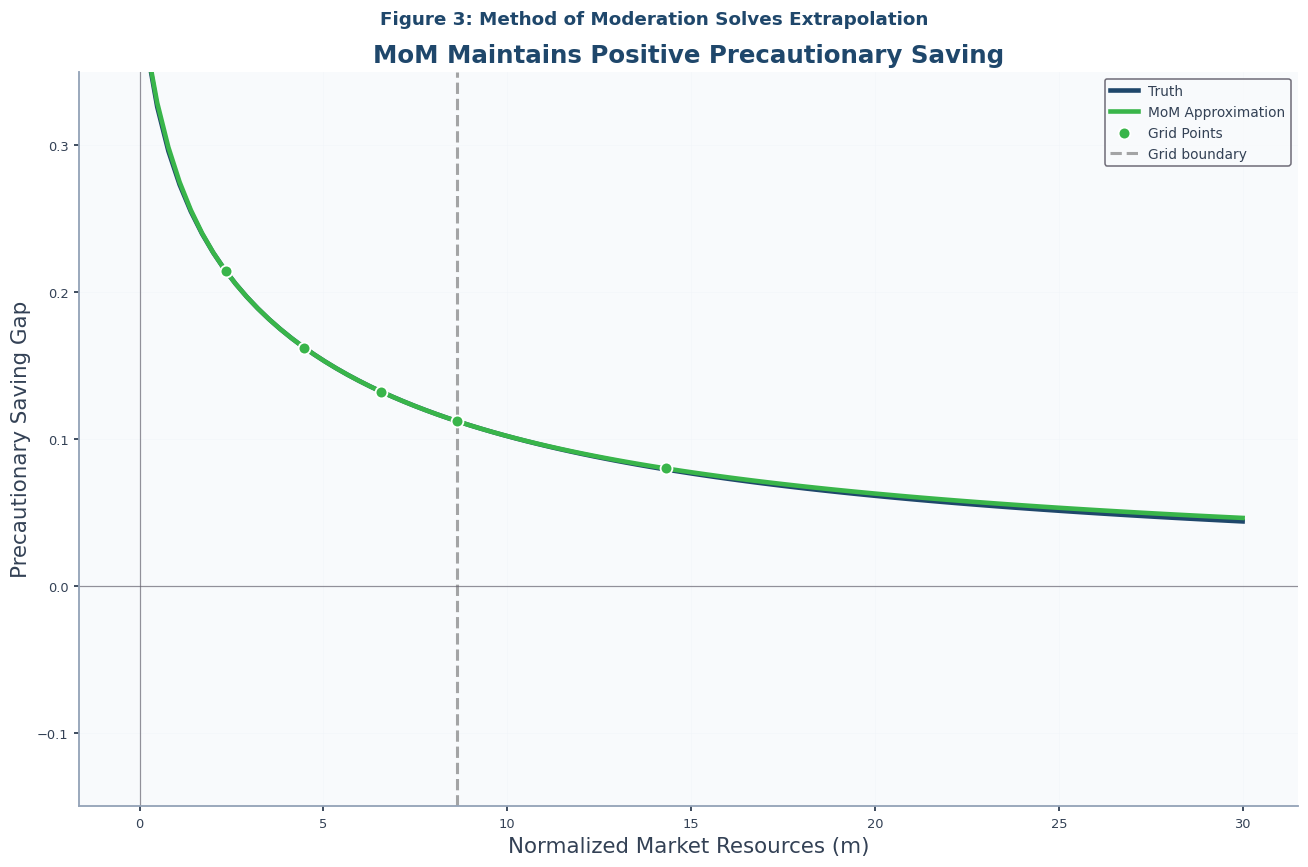

In [5]:
# Define MoM gap function
def mom_approx_gap(m):
    """MoM approximation gap."""
    return TruthOpt.cFunc(m) - IndShockMoMApproxSol.cFunc(m)


# Figure 3: Method of Moderation Success
# Grid points will be handled internally by plotting functions

plot_precautionary_gaps(
    m_grid=m_grid_wide,
    truth_gap=truth_gap(m_grid_wide),
    approx_gap=mom_approx_gap(m_grid_wide),
    legend="MoM Approximation",
    title="Figure 3: Method of Moderation Solves Extrapolation",
    subtitle="MoM Maintains Positive Precautionary Saving",
    solution=IndShockMoMApproxSol,
    grid_points=True,
)

# Optional: Example of plotting multiple methods on same figure
# plot_precautionary_gaps(
#     m_grid=m_grid_wide,
#     truth_gap=truth_gap(m_grid_wide),
#     approx_gap=[egm_approx_gap(m_grid_wide), mom_approx_gap(m_grid_wide)],
#     legend=["EGM Approximation", "MoM Approximation"],
#     title="Figure 3: Method Comparison",
#     subtitle="EGM vs MoM Extrapolation Performance",
#     solution=IndShockMoMApproxSol,  # Can use either solution for grid points
#     grid_points=True,
# )

```{important} Method of Moderation Success
**Success Demonstrated**: Method of Moderation maintains positive precautionary saving even when extrapolating far beyond its computed grid range, matching the high-precision truth.
```

The Method of Moderation builds on EGM's computational strengths while addressing the extrapolation challenge through economic theory. Following [the paper's algorithm](moderation.md#the-method-of-moderation), the key insight is that optimal consumption is always bounded between the optimist and pessimist consumption functions, both of which have known analytical solutions.

(notebook:algorithm)=
```{note} MoM Algorithm Details
:class: dropdown

Instead of extrapolating consumption directly (which can violate bounds), MoM follows these steps (notation matches the paper):
1. **Solve standard EGM** to get realist consumption at gridpoints
2. **Transform to log excess resources** $\logmNrmEx = \log(\mNrm - \mNrmMin)$ for convenient interpolation domain
3. **Compute moderation ratio** $\modRte(\logmNrmEx) = \dfrac{\cFuncOpt - \cFuncReal}{\hNrmEx\,\MPCmin} = \dfrac{\cFuncOpt - \cFuncReal}{\cFuncOpt - \cFuncPes} \in [0,1]$ (paper Eq. {eq}`eq:koppa`)
4. **Apply transformation** $\logitModRteFunc(\logmNrmEx) = \log((1-\modRte)/\modRte)$ for asymptotic linearity
5. **Interpolate $\logitModRteFunc(\logmNrmEx)$ function** with derivatives for smooth extrapolation
6. **Reconstruct consumption** using $\cFuncReal = \cFuncOpt - \modRte \cdot (\cFuncOpt - \cFuncPes)$

This approach ensures consumption always stays within economic bounds while achieving excellent extrapolation properties through the asymptotically linear transformation function, as {ref}`derived in the paper <the-consumption-function>`.

```

```{note} The Transformation: Mathematical Elegance
The transformation function is mathematically elegant because it transforms the bounded ratio $\modRte \in (0,1)$ into an unbounded space $\logitModRteFunc \in (-\infty, +\infty)$. More importantly, it becomes asymptotically linear as wealth increases. In our baseline calibration, the slope $\logitModRteMu$ tends to a small positive constant (not to zero). This positive limiting slope reflects the fact that the moderation ratio $\modRte$ converges to a constant strictly between 0 and 1 as $\mNrm \to \infty$.
```

(notebook:figure4)=
### Figure 4: MoM Consumption Function

Let's examine the consumption functions themselves to understand how `MoM` achieves superior extrapolation by staying within theoretical bounds.

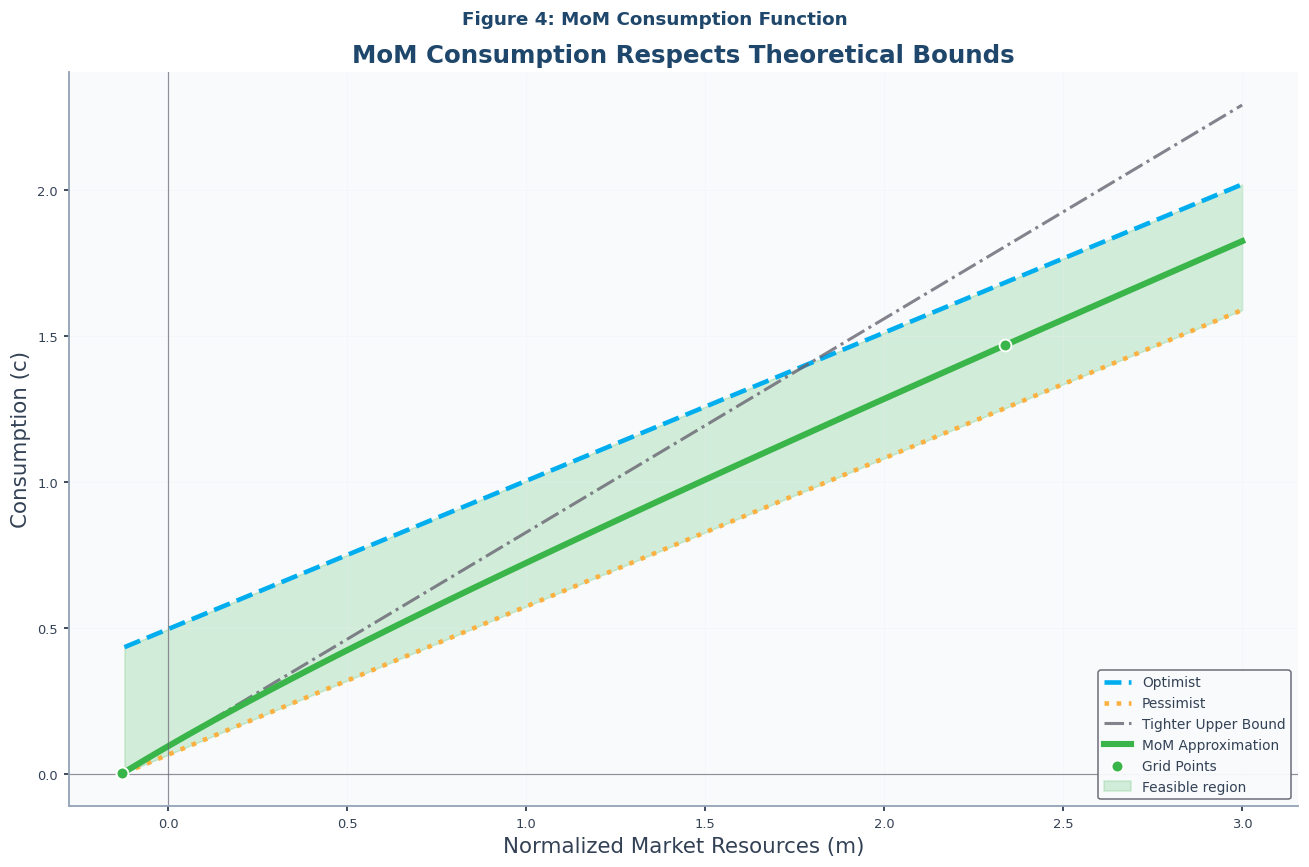

In [6]:
# Create specific grid for Figure 4 with max point at 3.0
m_grid_fig4 = np.linspace(IndShockTruthSol.mNrmMin + 0.01, 3.0, 100)

# Evaluate consumption functions for comparison at Figure 4 grid points
c_mom_fig4 = IndShockMoMApproxSol.cFunc(m_grid_fig4)  # MoM consumption
c_opt_fig4 = TruthOpt.cFunc(m_grid_fig4)  # Optimist consumption
c_pes_fig4 = TruthPes.cFunc(m_grid_fig4)  # Pessimist consumption
c_tight_fig4 = TruthTight.cFunc(m_grid_fig4)  # Tight upper bound

# Figure 4: MoM Consumption Function
plot_consumption_bounds(
    m_grid=m_grid_fig4,
    c_main=c_mom_fig4,
    c_opt=c_opt_fig4,
    c_pes=c_pes_fig4,
    title="Figure 4: MoM Consumption Function",
    subtitle="MoM Consumption Respects Theoretical Bounds",
    legend="MoM Approximation",
    c_tight=c_tight_fig4,  # Automatically shown since c_tight is provided
    solution=IndShockMoMApproxSol,
)

**Bound Preservation**: MoM consumption stays within theoretical bounds and below tight bound.

(notebook:figure5)=
### Figure 5: Direct Method Comparison

This decisive comparison shows why the Method of Moderation is superior to standard EGM for sparse grid problems. All three methods use the same sparse input data, but only MoM maintains economically sensible extrapolation behavior.

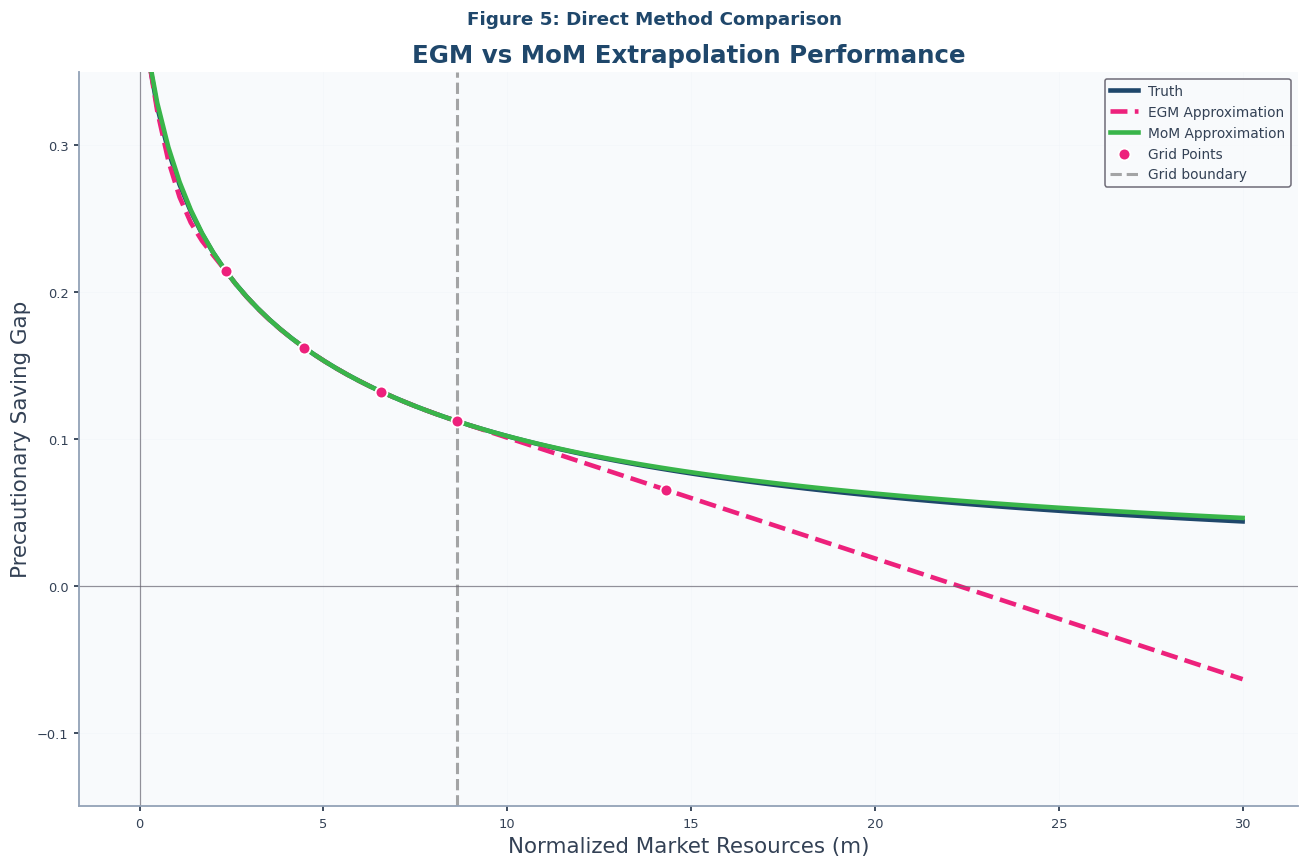

In [7]:
# Use the same wide grid for consistent comparison
m_grid_comparison = m_grid_wide

# Combined comparison: Truth, EGM failure, and MoM success
plot_precautionary_gaps(
    m_grid=m_grid_comparison,
    truth_gap=truth_gap(m_grid_comparison),
    approx_gap=[egm_approx_gap(m_grid_comparison), mom_approx_gap(m_grid_comparison)],
    legend=["EGM Approximation", "MoM Approximation"],
    title="Figure 5: Direct Method Comparison",
    subtitle="EGM vs MoM Extrapolation Performance",
    solution=IndShockMoMApproxSol,  # Use MoM solution for grid points
    grid_points=True,
)

```{important} The Decisive Advantage
This single figure demonstrates MoM's core advantage: given identical sparse grid data, **EGM produces economically impossible negative precautionary saving** (violating fundamental economic theory), while **MoM maintains positive precautionary saving** that closely matches the high-precision truth. The Method of Moderation solves the extrapolation problem that has long plagued sparse grid implementations of EGM.
```

(notebook:figure6)=
## Method of Moderation Framework

### Figure 6: Moderation Ratio Function $\modRte(\mNrm)$

The moderation ratio $\modRte(\mNrm)$ quantifies how the realist consumer balances between optimist and pessimist behaviors at different wealth levels (see {eq}`eq:koppa`). It ranges from 0 to 1, where:
- **$\modRte = 0$**: Realist behaves like optimist (perfect foresight, high wealth)
- **$\modRte = 1$**: Realist behaves like pessimist (worst-case expectations, low wealth)
- **$0 < \modRte < 1$**: Balanced moderation based on uncertainty

The moderation ratio follows the formula: $\modRte(\logmNrmEx) = (\cFuncOpt - \cFuncReal) / (\cFuncOpt - \cFuncPes)$, providing the foundation for the Method of Moderation's superior extrapolation properties.

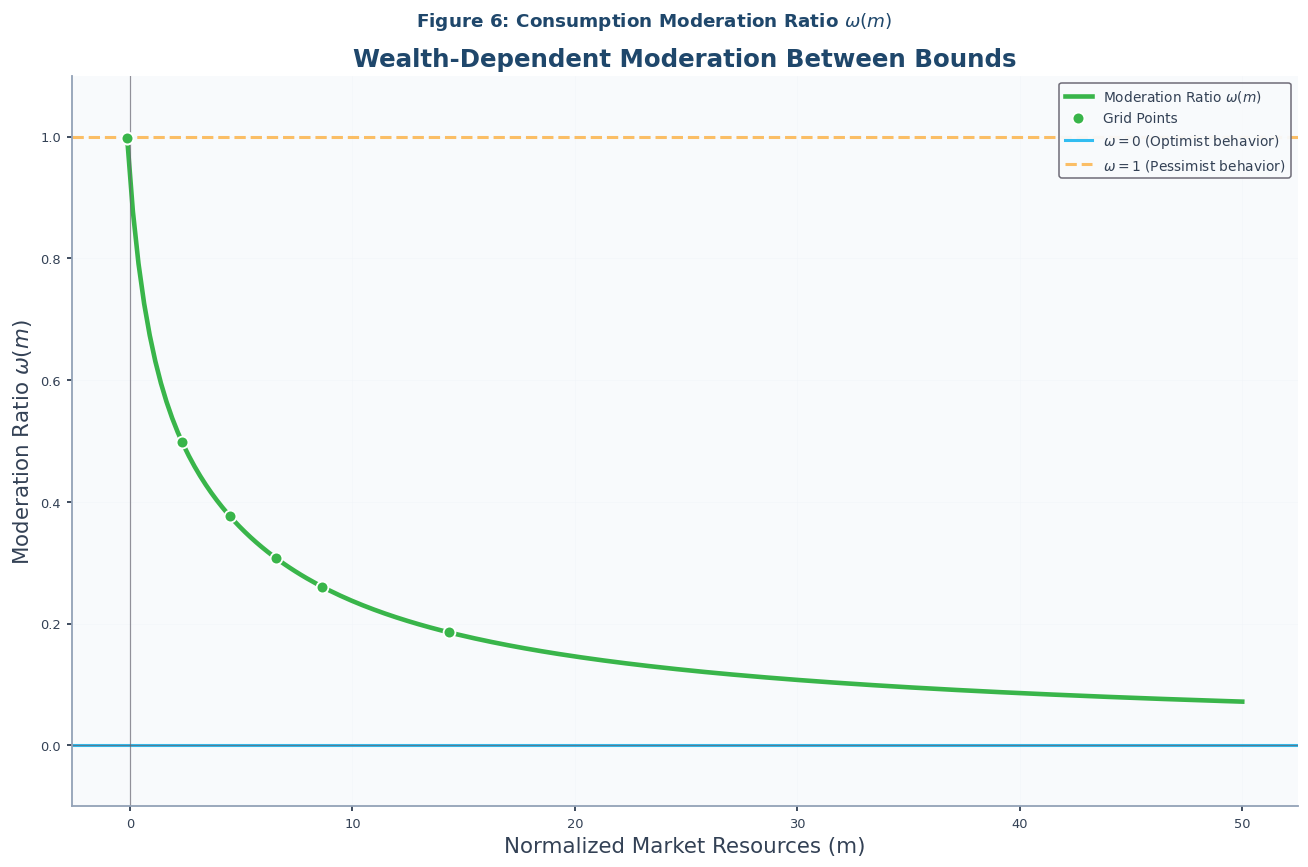

In [8]:
# Create grid mirroring paper's wide evaluation range
m_grid_fig5 = np.linspace(IndShockMoMApproxSol.mNrmMin + 0.01, 50, 200)

# Access the moderation functions from the MoM solution
transformed_func = IndShockMoMApproxSol.cFunc  # TransformedFunctionMoM
modRteFunc = transformed_func.modRteFunc  # $\modRte(\logmNrmEx)$ function
logitModRteFunc = transformed_func.logitModRteFunc  # transformation function

# Convert market resources to $\logmNrmEx$ ("mu" in the paper: $\logmNrmEx = \log(\mNrm-\mNrmMin)$)
from moderation import expit_moderate, log_mnrm_ex

m_min = transformed_func.mNrmMin
mu_grid_fig5 = log_mnrm_ex(m_grid_fig5, m_min)

# Evaluate moderation ratio $\modRte(\logmNrmEx)$ via transformation and inverse
chi_values_fig5 = logitModRteFunc(mu_grid_fig5)
omega_values_fig5 = expit_moderate(chi_values_fig5)

# Figure 6: Moderation Ratio Function (paper Fig. 6 counterpart)
plot_moderation_ratio(
    m_grid=m_grid_fig5,
    omega_values=omega_values_fig5,
    title=r"Figure 6: Consumption Moderation Ratio $\omega(m)$",
    subtitle="Wealth-Dependent Moderation Between Bounds",
    solution=IndShockMoMApproxSol,
    grid_type="consumption",
)

```{note} Economic Interpretation of $\modRte(\mNrm)$
The moderation ratio reveals the consumer's **risk management strategy**:

- **High wealth** ($\mNrm > 10$): $\modRte \to 0$, realist approaches optimist behavior as uncertainty becomes less important
- **Low wealth** ($\mNrm \approx \mNrmMin$): $\modRte \to 1$, realist approaches pessimist behavior due to high precautionary motives
- **Middle wealth**: $\modRte \in (0,1)$, balanced moderation reflecting partial prudence

This intuitive pattern ensures that MoM consumption functions have proper economic behavior across the entire wealth distribution, unlike linear extrapolation methods that can violate economic bounds.
```

(notebook:figure7)=
### Figure 7: The Logit Transformation

The logit transformation $\logitModRte(\logmNrmEx) = \log((1-\modRte)/\modRte)$ enables asymptotically linear interpolation in unbounded space $(-\infty,\infty)$.

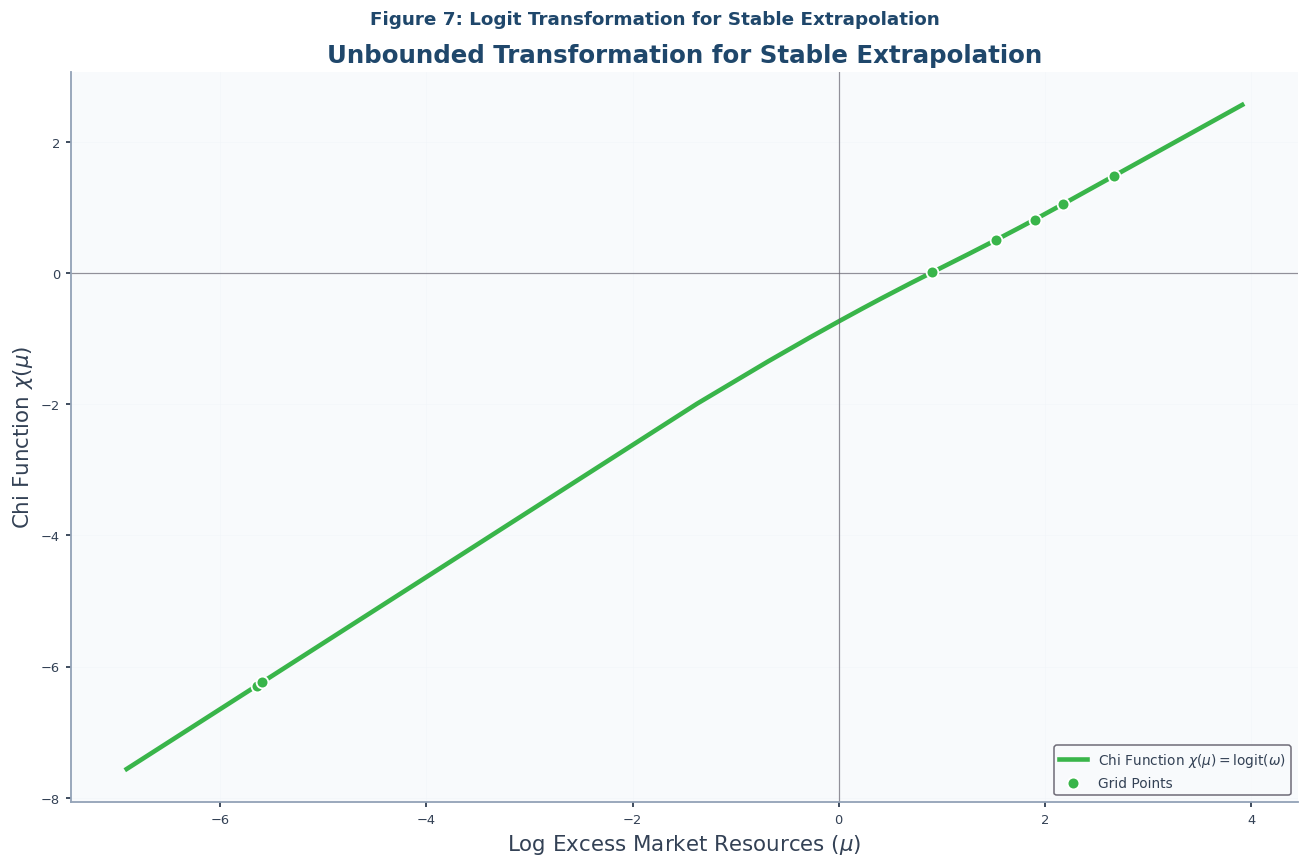

In [9]:
# Create market resources grid from near constraint to high wealth to show full behavior
m_grid_wide = np.linspace(m_min + 0.001, 50, 200)

# Convert to mu grid for x-axis (this is the natural domain for logit function)
mu_grid_chi = log_mnrm_ex(m_grid_wide, m_min)

# Evaluate logit function over this extended range
chi_values_fig6 = logitModRteFunc(mu_grid_chi)

# Figure 7: Logit Transformation Function plotted over mu (log excess resources)
# X-axis will be mu = log(m - mNrmMin), Y-axis will be logit(omega)
plot_chi_function(
    mu_grid=mu_grid_chi,  # mu values for x-axis (log excess market resources)
    chi_values=chi_values_fig6,
    title="Figure 7: Logit Transformation for Stable Extrapolation",
    subtitle="Unbounded Transformation for Stable Extrapolation",
    solution=IndShockMoMApproxSol,
    grid_points=True,
)

```{important} Why Asymptotic Linearity Matters
As $\logmNrmEx \to \infty$ (high wealth), the $\logitModRte(\logmNrmEx)$ curve becomes approximately linear with a positive slope $\logitModRteMu>0$. This asymptotic linearity is crucial because:

1. **Prevents extrapolation errors**: Unlike linear methods that can predict negative precautionary saving, MoM's linear extrapolation preserves economic theory
2. **Ensures convergence**: The consumption function approaches the optimist bound smoothly without oscillation
3. **Maintains stability**: Small numerical errors don't compound into large extrapolation mistakes

This asymptotic linearity with positive slope is what prevents the extrapolation errors that plague standard endogenous grid methods.
```

```{note} Mathematical Properties of $\logitModRte(\logmNrmEx)$
The logit transformation exhibits several key properties visible in the figure (with $\logitModRteMu>0$):

- **Unbounded domain**: $\logitModRte \in (-\infty, \infty)$ allows smooth interpolation without artificial constraints
- **Monotonically decreasing**: Higher wealth (larger $\logmNrmEx$) corresponds to lower $\logitModRte$ values (closer to optimist behavior)
- **Asymptotic linearity with positive slope**: $\logitModRteMu>0$ as $\logmNrmEx \to \infty$, ensuring stable extrapolation
- **Economic interpretation**:
  - $\logitModRte > 0$: Realist closer to optimist (low precautionary saving)
  - $\logitModRte < 0$: Realist closer to pessimist (high precautionary saving)
  - $\logitModRte \approx 0$: Balanced between extremes

This mathematical elegance translates directly into superior numerical properties for consumption function approximation.
```

(notebook:figure8)=
## Function Properties and Bounds

### Figure 8: MoM MPC Bounded by Theory

The marginal propensity to consume ($\MPC$) tells us how much additional consumption results from an additional dollar of market resources. This is crucial for understanding:
- **Monetary policy transmission**: How interest rate changes affect spending
- **Fiscal policy effectiveness**: How tax rebates stimulate consumption
- **Wealth effects**: How asset price changes impact the economy

Like consumption, the MPC must also respect theoretical bounds between $\MPCmin$ and $\MPCmax$, as {ref}`shown in the paper's extensions <a-tighter-upper-bound>`.

```{important} Policy Applications: Why MPC Bounds Matter
In practice, bounded MPC estimates are crucial for policy analysis. If a DSGE model predicts unrealistic MPC values (>1 or <0) due to extrapolation errors, policy multipliers become nonsensical. The Method of Moderation ensures MPC values always remain economically meaningful, making it particularly valuable for Federal Reserve DSGE models used in monetary policy analysis.
```

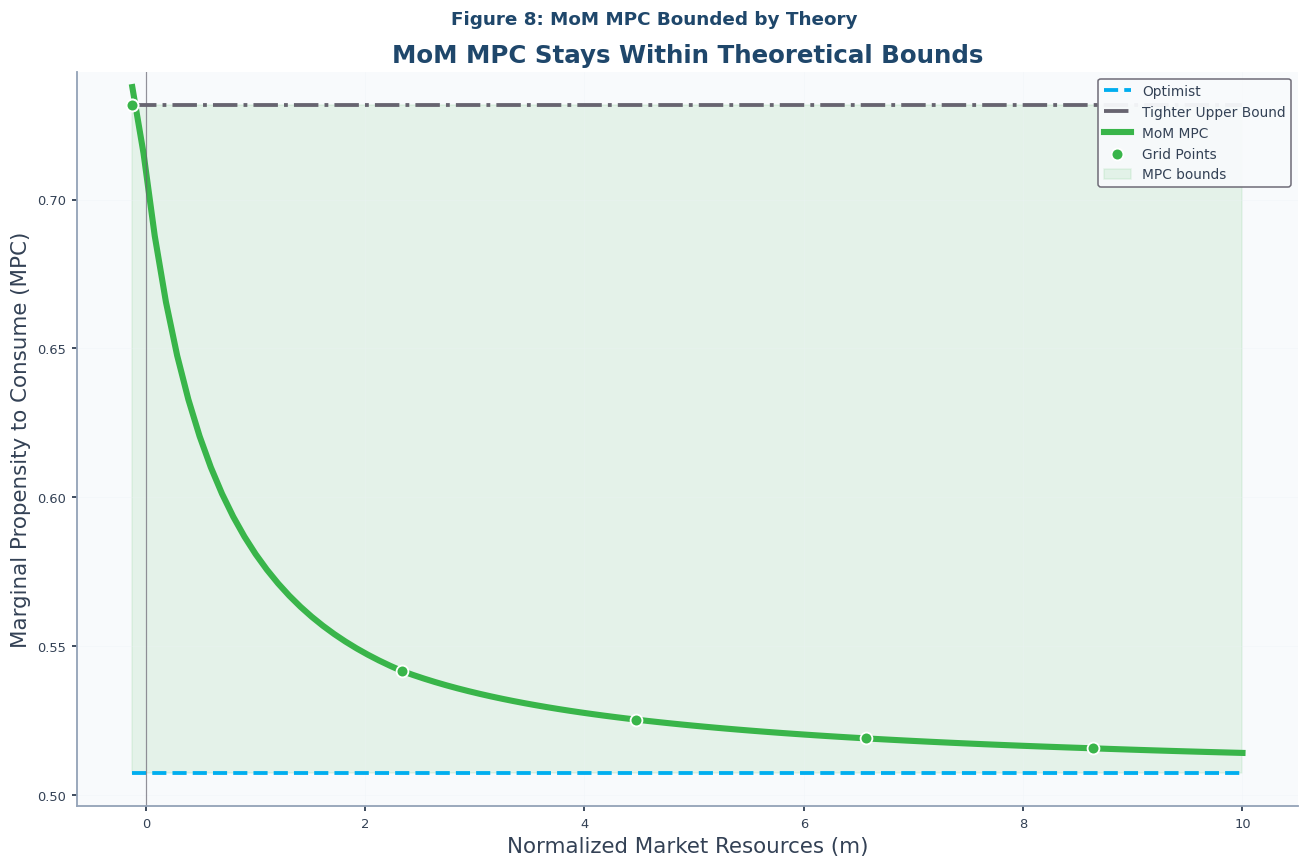

In [10]:
# Calculate MPCs - now using the implemented MoM MPC derivative
mpc_mom = IndShockMoMApproxSol.cFunc.derivative(m_grid)  # MoM MPC (varies with wealth)
mpc_opt_const = IndShockTruthSol.MPCmin  # Optimist MPC (constant)
mpc_tight_const = IndShockTruthSol.MPCmax  # Tight bound MPC (constant)

# Create constant arrays for plotting
mpc_opt_vals = np.full_like(m_grid, mpc_opt_const)
mpc_tight_vals = np.full_like(m_grid, mpc_tight_const)

# Figure 8: MoM MPC Bounds
plot_mom_mpc(
    m_grid=m_grid,
    mpc_values=mpc_mom,
    mpc_opt_vals=mpc_opt_vals,
    mpc_tight_vals=mpc_tight_vals,
    title="Figure 8: MoM MPC Bounded by Theory",
    subtitle="MoM MPC Stays Within Theoretical Bounds",
    mpc_label="MoM MPC",
    solution=IndShockMoMApproxSol,
    grid_points=True,  # Explicitly enable grid points
)

```{note} MPC Economic Interpretation
**MPC Bounds Respected**: The MoM marginal propensity to consume declines with $\mNrm$ as theory predicts, staying between $\MPCmin$ and $\MPCmax$. This reflects fundamental economic principles:

- **Poor consumers** spend windfalls immediately (high $\MPC$, approaching $\MPCmax$)
- **Rich consumers** save most windfalls (low $\MPC$, approaching $\MPCmin$)
- This reflects **diminishing marginal utility** of consumption
- $\MPC$ decline shows wealth effects diminish with higher market resources
- Linear consumption functions have constant $\MPC$ reflecting perfect-foresight assumptions

The bounds ensure that $\MPC$ values remain economically sensible, with the realist $\MPC$ lying between the tight upper bound $\MPCmax$ and optimist lower bound $\MPCmin$.
```

(notebook:figure9)=
### Figure 9: Value Functions Bounded by Theory

The value function represents the consumer's expected lifetime utility as a function of current market resources. This figure shows the theoretical bounds (optimist and pessimist) along with the EGM sparse grid approximation, demonstrating how well the 5-point grid captures value function behavior between the analytical limits.

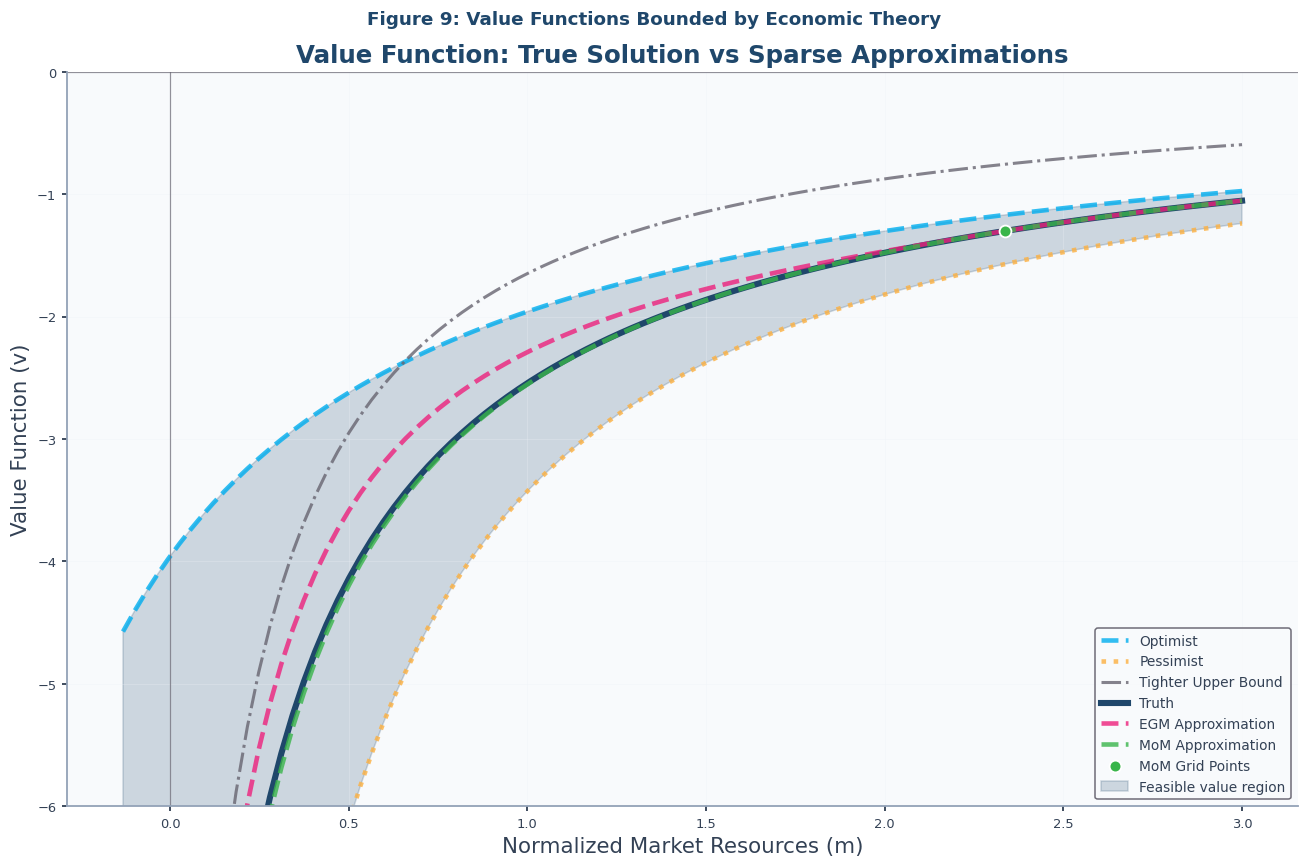

In [11]:
# Create wealth grid specifically for value functions (starting from mNrmMin + 0.001)
m_grid_vfunc = np.linspace(IndShockEGMApproxSol.mNrmMin + 0.001, 3.0, 100)

# Evaluate value functions on the grid
v_truth = IndShockTruthSol.vFunc(m_grid_vfunc)  # Truth
v_opt = TruthOpt.vFunc(m_grid_vfunc)  # Optimist
v_pes = TruthPes.vFunc(m_grid_vfunc)  # Pessimist
v_tight = TruthTight.vFunc(m_grid_vfunc)  # Tight upper bound
v_egm_sparse = IndShockEGMApproxSol.vFunc(
    m_grid_vfunc,
)  # EGM Approximation
v_mom_sparse = IndShockMoMApproxSol.vFunc(m_grid_vfunc)  # MoM Approximation

# Figure 9: Value Functions (truth, optimist, pessimist, tight, EGM, MoM)
plot_value_functions(
    m_grid=m_grid_vfunc,
    title="Figure 9: Value Functions Bounded by Economic Theory",
    subtitle="Value Function: True Solution vs Sparse Approximations",
    v_truth=v_truth,
    v_opt=v_opt,
    v_pes=v_pes,
    v_tight=v_tight,
    v_egm_sparse=v_egm_sparse,
    v_mom_sparse=v_mom_sparse,
    figure_num=7,
    mom_solution=IndShockMoMApproxSol,
    egm_solution=None,
)

```{note} Value Function Economic Interpretation
This figure shows the **theoretical bounds**, **sparse approximations**, and **truth solution**:

- **Truth** (blue) - realist solution with uncertainty
- **Optimist** (light blue) - highest possible utility
- **Pessimist** (yellow) - lowest possible utility
- **Tighter Upper Bound** (orange) - refined upper bound using maximum MPC
- **EGM Approximation** (pink) - sparse grid approximation
- **MoM Approximation** (green) - Method of Moderation approximation with visible grid points

Both EGM and MoM approximations use the same 5 sparse grid points, but MoM provides superior approximation quality, staying closer to the truth solution while respecting all theoretical bounds. The grid points (shown only for MoM to avoid duplication) reveal exactly where the sparse interpolation nodes are located, demonstrating the efficiency of the Method of Moderation approach.

The gap between optimist and pessimist values represents the **cost of uncertainty** - how much lifetime utility is reduced when facing income uncertainty rather than perfect foresight.
```

```{note} Economic Insight: The Value of Certainty
The gap between optimist and pessimist value functions reflects a fundamental economic principle: uncertainty matters most for those with little wealth. For poor consumers, income uncertainty dramatically affects optimal choices and reduces lifetime utility significantly. For wealthy consumers, large asset buffers provide natural insurance, making the difference between best-case and worst-case scenarios less pronounced. This explains why wealth inequality amplifies the welfare costs of economic uncertainty.
```

(notebook:figure10)=
### Figure 10: Inverse Value Functions $\vInv(\mNrm)$

The inverse value function $\vInv(\mNrm) = u^{-1}(v(\mNrm))$ represents the consumption equivalent of the value function - the constant consumption level that would provide the same lifetime utility as the value function at each wealth level. This transformation is crucial for HARK's numerical stability and provides intuitive economic interpretation.

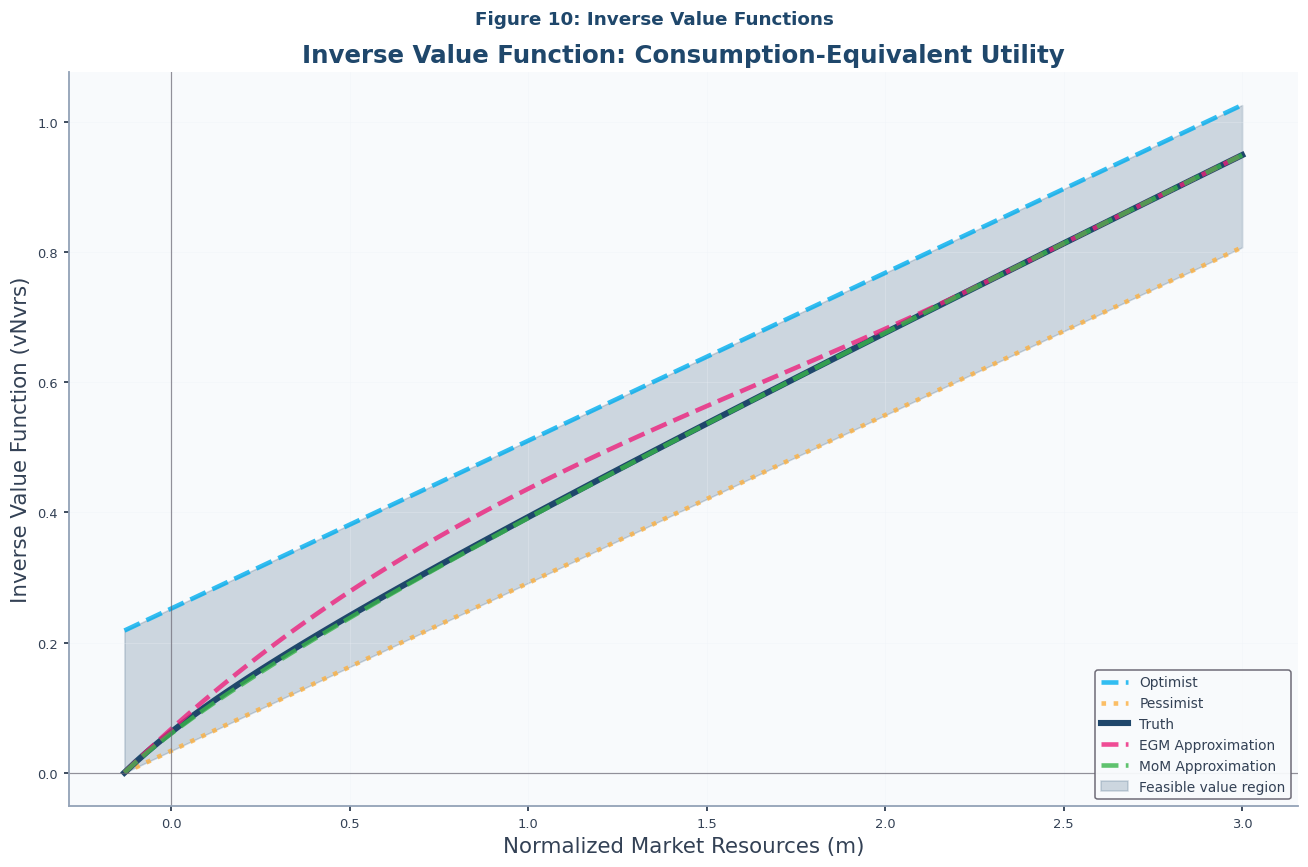

In [12]:
# Evaluate inverse value functions on the same grid as Figure 8
vNvrs_truth = IndShockTruthSol.vFunc.vFuncNvrs(m_grid_vfunc)  # Truth inverse value
vNvrs_opt = TruthOpt.vFunc.vFuncNvrs(m_grid_vfunc)  # Optimist inverse value
vNvrs_pes = TruthPes.vFunc.vFuncNvrs(m_grid_vfunc)  # Pessimist inverse value
vNvrs_egm_sparse = IndShockEGMApproxSol.vFunc.vFuncNvrs(
    m_grid_vfunc,
)  # EGM inverse value
vNvrs_mom_sparse = IndShockMoMApproxSol.vFunc.vFuncNvrs(
    m_grid_vfunc,
)  # MoM inverse value

# Figure 10: Inverse Value Functions
plot_value_functions(
    m_grid=m_grid_vfunc,
    title="Figure 10: Inverse Value Functions",
    subtitle="Inverse Value Function: Consumption-Equivalent Utility",
    v_truth=vNvrs_truth,
    v_opt=vNvrs_opt,
    v_pes=vNvrs_pes,
    v_tight=None,
    v_egm_sparse=vNvrs_egm_sparse,
    v_mom_sparse=vNvrs_mom_sparse,
    figure_num=8,
    mom_solution=IndShockMoMApproxSol,
    egm_solution=IndShockEGMApproxSol,
)

```{note} Inverse Value Function Economic Interpretation
The inverse value functions provide an intuitive consumption-equivalent interpretation of lifetime utility:

- **Truth** (blue) - consumption equivalent of realist lifetime utility
- **Optimist** (light blue) - consumption equivalent with no uncertainty
- **Pessimist** (yellow) - consumption equivalent with worst-case scenarios
- **EGM Approximation** (pink) - sparse grid approximation
- **MoM Approximation** (green) - Method of Moderation approximation

The inverse transformation $\vInv(\mNrm) = u^{-1}(v(\mNrm))$ converts utility units into consumption units, making the economic interpretation more intuitive. For example, if $\vInv(5) = 0.8$, then having 5 units of wealth provides the same lifetime utility as consuming 0.8 units forever.

The ordering and gaps between inverse value functions mirror those in Figure 8, but the inverse transformation linearizes the problem near the borrowing constraint, which is why HARK uses this representation for numerical interpolation.
```

(notebook:figure11)=
### Figure 11: Value Function Moderation Ratio

The Method of Moderation applies generally to any bounded function. For inverse value functions, the moderation principle works exactly the same as for consumption functions.

The value function moderation ratio is simply: $\valModRte(\logmNrmEx) = \frac{\vInvOpt - \vInvReal}{\vInvOpt - \vInvPes}$, where higher $\valModRte$ indicates the realist inverse value is closer to the pessimist bound (reflecting higher uncertainty effects).

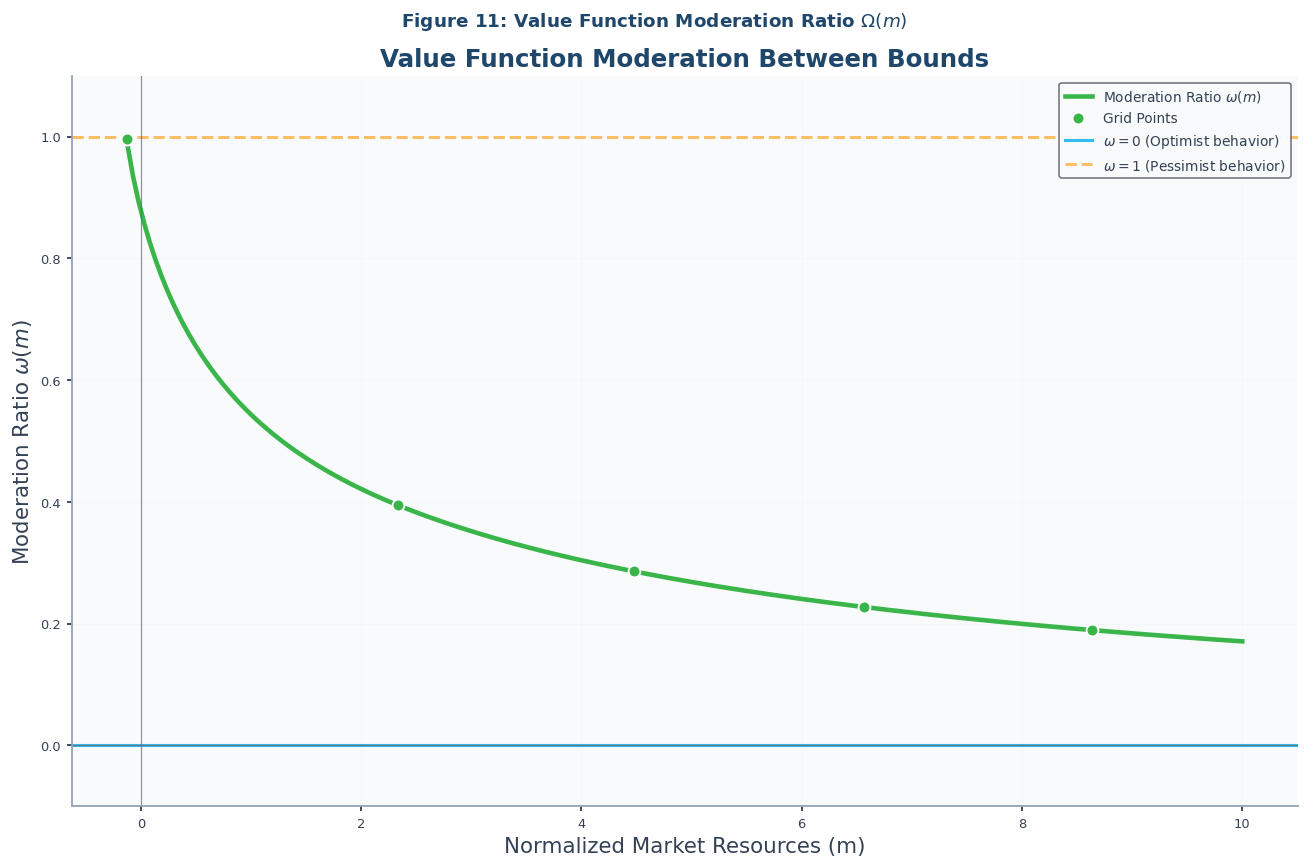

In [13]:
# Access the value function moderation functions from the MoM solution
# Extract value function moderation functions
vfunc_transformed = (
    IndShockMoMApproxSol.vFunc.vFuncNvrs
)  # TransformedFunctionMoM for value function
vfunc_modRteFunc = (
    vfunc_transformed.modRteFunc
)  # $\valModRte(\logmNrmEx)$ function for value function
vfunc_logitModRteFunc = (
    vfunc_transformed.logitModRteFunc
)  # $\logitValModRte(\logmNrmEx)$ function for value function

# Create specific grid for Figure 10 with xlim at 10
m_grid_vfunc_mod = np.linspace(IndShockMoMApproxSol.mNrmMin + 0.01, 10, 200)

# Convert to $\logmNrmEx$ for evaluation
mu_grid_vfunc = log_mnrm_ex(m_grid_vfunc_mod, m_min)

# Evaluate value function moderation ratio $\valModRte(\logmNrmEx)$ by using chi function and inverse transformation
vfunc_chi_values = vfunc_logitModRteFunc(mu_grid_vfunc)
vfunc_omega_values = expit_moderate(vfunc_chi_values)

# Figure 11: Value Function Moderation Ratio
plot_moderation_ratio(
    m_grid=m_grid_vfunc_mod,
    omega_values=vfunc_omega_values,
    title=r"Figure 11: Value Function Moderation Ratio $\Omega(m)$",
    subtitle="Value Function Moderation Between Bounds",
    solution=IndShockMoMApproxSol,
    grid_type="value",
)

```{note} Value Function Moderation Interpretation
The value function moderation ratio reveals how **uncertainty affects lifetime utility**:

- **High wealth** ($\mNrm > 10$): $\valModRte \to 0$, realist inverse value approaches optimist inverse value as uncertainty becomes less costly
- **Low wealth** ($\mNrm \approx \mNrmMin$): $\valModRte \to 1$, realist inverse value approaches pessimist inverse value due to high uncertainty costs
- **Middle wealth**: $\valModRte \in (0,1)$, balanced assessment of uncertainty's utility impact on inverse values

This pattern shows that uncertainty's welfare cost diminishes with wealth, providing economic insight into the distributional effects of uncertainty.
```

## Summary: Why the Method of Moderation Matters

The figures demonstrate MoM's comprehensive solution to the sparse grid extrapolation problem:

**Core Innovation**: MoM transforms the bounded moderation ratio $\modRte \in [0,1]$ into an unbounded logit function $\logitModRte \in (-\infty, \infty)$ that becomes asymptotically linear, enabling stable extrapolation while respecting economic bounds $\cFuncPes(\mNrm) \leq \cFuncReal(\mNrm) \leq \cFuncOpt(\mNrm)$.

**Key Advantages**: MoM builds on EGM's efficiency while preventing extrapolation failures through theoretically-grounded bounds, ensuring reliable behavior for policy analysis and large-scale simulations.

For complete theoretical development see {ref}`the-method-of-moderation`.